## load data, separate features for PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV

In [2]:
%run ../Jane/extract_data.py

Your data is ready! Merged table name is zillow_full.


In [3]:
zillow_full = zillow_full.drop(['PersonalIncome','AQIMean','Vol_moderate_income','Vol_low_income'],axis=1)
# separate the cols that won't go into the pca
zillow = zillow_full[['Zipcode','City','State','Metro','County','SizeRank','Date','Rent','Year','State-County']].copy()
features = zillow_full.drop(['Zipcode','City','State','Metro','County','SizeRank','Date','Rent',
                             'Year','State-County'], axis = 1).copy()

In [4]:
features = pd.DataFrame(normalize(features,axis=0),columns=features.columns) # normalized data

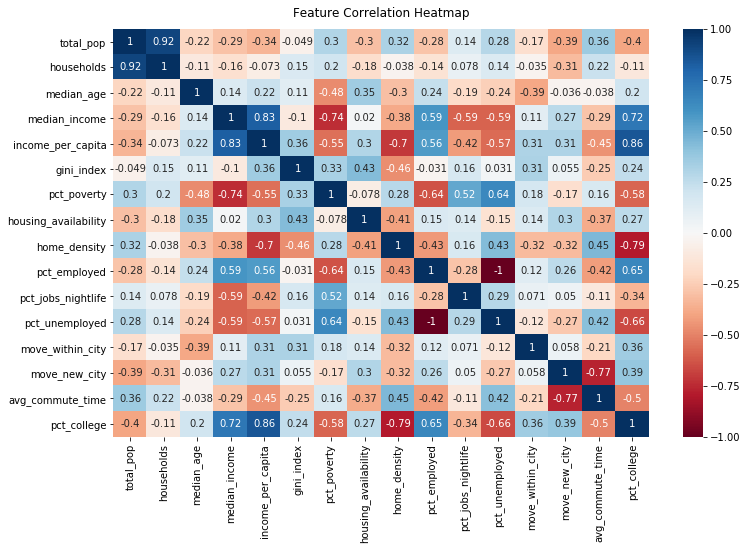

In [5]:
# Assess correlations between features for multicollinearity
plt.figure(figsize=(12, 7.5)) # larger for ease of viewing

heatmap = sns.heatmap(features.corr(), vmin=-1, vmax=1, annot=True,cmap="RdBu")
heatmap.set_title('Feature Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## PCA 1: socioeconomic features

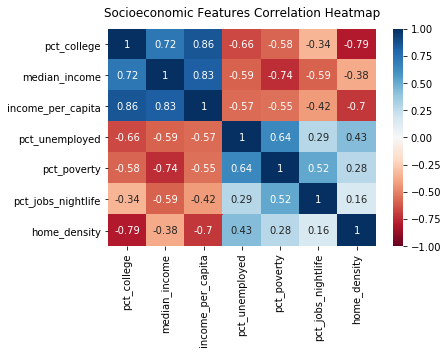

In [6]:
# check correlations
socioeconomic = features[['pct_college','median_income','income_per_capita','pct_unemployed','pct_poverty',
                          'pct_jobs_nightlife','home_density']]
heatmap = sns.heatmap(socioeconomic.corr(), vmin=-1, vmax=1, annot=True,cmap="RdBu")
heatmap.set_title('Socioeconomic Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [7]:
from PCARandomForest import screePlot, featurePlotPCA # local .py file

[0.68583226 0.12615667 0.08875063 0.04543429 0.03245818 0.01646351
 0.00490446]


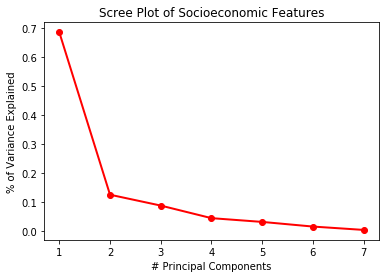

In [8]:
screePlot(socioeconomic, df_name = "Socioeconomic Features") # 3 principal components is sufficient

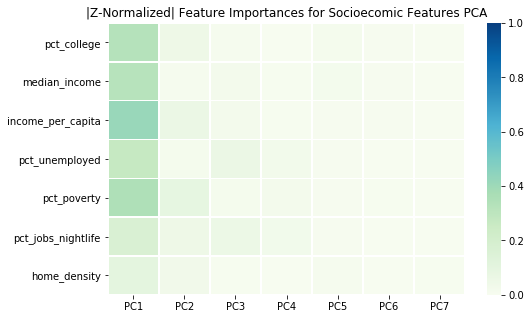

In [8]:
featurePlotPCA(socioeconomic, df_name='Socioecomic Features')

In [9]:
pca = PCA(n_components=3) 
econPC = pd.DataFrame(pca.fit_transform(socioeconomic),columns=['econPC1','econPC2','econPC3'])

In [10]:
# remove features from feature df if they were included in the above PCA
features = features.drop(['pct_college','median_income','income_per_capita','pct_unemployed','pct_poverty',
                          'pct_jobs_nightlife','home_density'],axis=1)

In [11]:
# PCA above used the feature pct_unemployed. 1 - pct_employed = pct_employed ; this is a redundant feature -
# drop it from the feature df
features = features.drop(['pct_employed'],axis=1)

## PCA 2: zip code-level features ("neighborhood/city features")

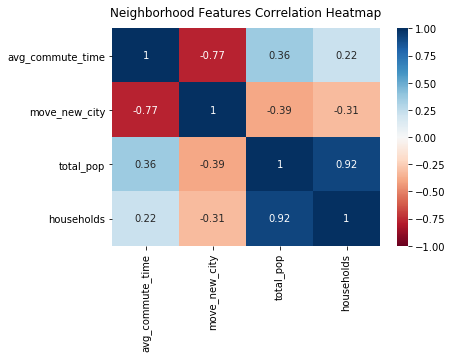

In [14]:
# select a second subset of features; check corrs
cityfeats = features[['avg_commute_time','move_new_city','total_pop','households']]
heatmap = sns.heatmap(cityfeats.corr(), vmin=-1, vmax=1, cmap="RdBu", annot=True)
heatmap.set_title('Neighborhood Features Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

[0.65766925 0.29605257 0.03255909 0.01371908]


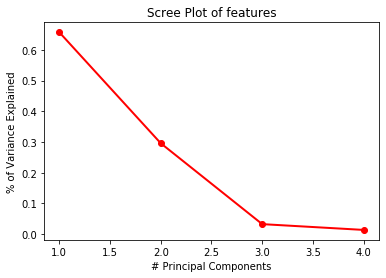

In [15]:
screePlot(cityfeats) # 2 prinicipal components seem sufficient

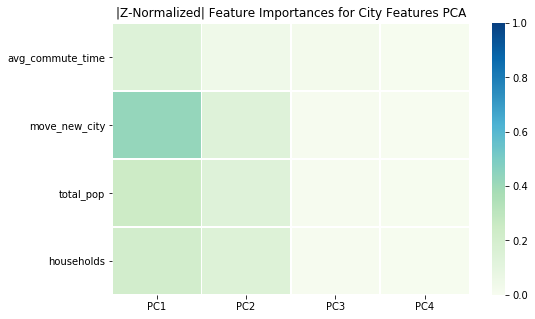

In [16]:
featurePlotPCA(cityfeats, df_name='City Features')

In [17]:
pca = PCA(n_components=2) 
cityPC = pd.DataFrame(pca.fit_transform(cityfeats),columns=['cityPC1','cityPC2'])

In [18]:
# remove features from feature df if they were included in the above PCA
features = features.drop(['avg_commute_time','move_new_city','total_pop','households'],axis=1)

## recombine to one dataframe

In [19]:
zillow_withPCA = pd.concat((zillow[['Zipcode','Date','Rent']],features,cityPC,econPC),axis=1)
zillow_withPCA.set_index('Date',inplace=True)

In [20]:
zillow_withPCA.head()
#zillow_withPCA.to_csv('../../data/zillow_withPCA.csv')

,Zipcode,Rent,median_age,gini_index,housing_availability,move_within_city,cityPC1,cityPC2,econPC1,econPC2,econPC3
Date,,,,,,,,,,,
2015-01-01,10025,3566.0,0.008120,0.009306,0.007598,0.008591,-0.007053,0.009281,0.003816,0.002187,0.002316
2015-01-01,10023,3413.0,0.008513,0.008738,0.008109,0.007416,-0.004638,0.004340,0.012160,0.003883,0.002966
2015-01-01,10002,3508.0,0.008572,0.009103,0.007013,0.005223,-0.007252,0.004014,-0.005684,0.004695,-0.002163
2015-01-01,11226,1876.0,0.006822,0.007221,0.007228,0.004562,-0.010629,0.005907,-0.003696,-0.001239,0.000227
2015-01-01,10467,1442.0,0.006625,0.007500,0.006907,0.009433,-0.011097,0.006011,-0.009925,0.001891,0.003597


## random forest

In [20]:
from PCARandomForest import train_test, randForest

In [21]:
y = np.log(zillow_withPCA['Rent'])
X = zillow_withPCA.drop(['Rent'],axis=1)

In [22]:
Xtrain,Xtest,ytrain,ytest = train_test(X,y)

In [23]:
# try with only the PC cols
Xtrain = Xtrain.drop(['Zipcode','median_age','gini_index','housing_availability','move_within_city'],axis=1)
Xtest = Xtest.drop(['Zipcode','median_age','gini_index','housing_availability','move_within_city'],axis=1)

In [24]:
rfc = RandomForestRegressor(n_estimators=600)
randForest(rfc,Xtrain,Xtest,ytrain,ytest)

training R2: 0.9759590873907432
test R2: 0.9474868252406794
RMSE: 135.10329465088498


,Columns,Feature_importances
2,econPC1,0.450790
0,cityPC1,0.214362
4,econPC3,0.146673
3,econPC2,0.107438
1,cityPC2,0.080736


## grid search to parameter tune

In [29]:
param_grid = {'min_samples_split':[10,20,30,50,100],
              'min_samples_leaf':[5,10,20,35,50]
             }
grid = GridSearchCV(RandomForestRegressor(max_features='sqrt', n_estimators=500),
                    param_grid = param_grid,return_train_score=True,verbose=1)

In [30]:
# started running at 8:08:40 pm
grid.fit(Xtrain,ytrain)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:  7.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='sqrt',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=500, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [31]:
grid.best_params_

{'min_samples_leaf': 10, 'min_samples_split': 30}

In [48]:
grid_results = pd.DataFrame.from_dict(grid.cv_results_).set_index('params').sort_values('rank_test_score')
grid_results[['mean_test_score','mean_train_score','rank_test_score']].head()

,mean_test_score,mean_train_score,rank_test_score
params,,,
"{'min_samples_leaf': 10, 'min_samples_split': 30}",0.965538,0.977269,1
"{'min_samples_leaf': 5, 'min_samples_split': 30}",0.965531,0.977269,2
"{'min_samples_leaf': 10, 'min_samples_split': 20}",0.965524,0.977269,3
"{'min_samples_leaf': 10, 'min_samples_split': 10}",0.965522,0.977269,4
"{'min_samples_leaf': 5, 'min_samples_split': 10}",0.965515,0.977270,5


In [50]:
rfc = grid.best_estimator_
randForest(rfc,Xtrain,Xtest,ytrain,ytest) # we seem to be overfitting still

training R2: 0.9759589410498936
test R2: 0.9474635705796479
RMSE: 135.12355136046952


,Columns,Feature_importances
2,econPC1,0.415166
0,cityPC1,0.182093
4,econPC3,0.160518
1,cityPC2,0.126562
3,econPC2,0.115662


## validation data -> check ONLY non-imputed rents

In [55]:
ZRI = pd.read_csv('../../data/zillow/Zip_Zri_MultiFamilyResidenceRental.csv',dtype = {'RegionName':str})
from ValidationZipcodes import GetZipcodes # local .py file
GetZipcodes?

In [58]:
test_zips = GetZipcodes(ZRI)
validation_data = zillow_withPCA[zillow_withPCA.Zipcode.isin(test_zips)]

In [67]:
y2 = np.log(validation_data['Rent'])
X2 = validation_data.filter(regex='PC')

In [68]:
X2train,X2test,y2train,y2test = train_test(X2,y2)

In [71]:
rfc = grid.best_estimator_
randForest(rfc,X2train,X2test,y2train,y2test) # performs a little better with lower RMSE

training R2: 0.9821180710953172
test R2: 0.9588517104403985
RMSE: 108.23778139060856


,Columns,Feature_importances
2,econPC1,0.372451
0,cityPC1,0.235541
1,cityPC2,0.141165
4,econPC3,0.139700
3,econPC2,0.111142
